In [2]:
#importing the necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design (UUID: GPU-da82b679-5722-c473-7fc1-04a876d49f2a)


In [5]:
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)

True


In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names

In [10]:
def resize_images(image, label):
    image = tf.image.resize(image, size=(224,224))
    image = tf.cast(image, dtype = tf.float32)
    return image, label

In [11]:
train_data = train_data.map(map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#test_data doesn't need to be shuffled
test_data = test_data.map(map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

<Figure size 1600x1600 with 0 Axes>

<AxesSubplot: >

Text(0.5, 1.0, 'Class: oysters || Class_label: 69')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: gyoza || Class_label: 52')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: greek_salad || Class_label: 48')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: scallops || Class_label: 87')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: fried_rice || Class_label: 44')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: sushi || Class_label: 95')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: beet_salad || Class_label: 5')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: creme_brulee || Class_label: 27')

(-0.5, 223.5, 223.5, -0.5)

<AxesSubplot: >

Text(0.5, 1.0, 'Class: club_sandwich || Class_label: 25')

(-0.5, 223.5, 223.5, -0.5)

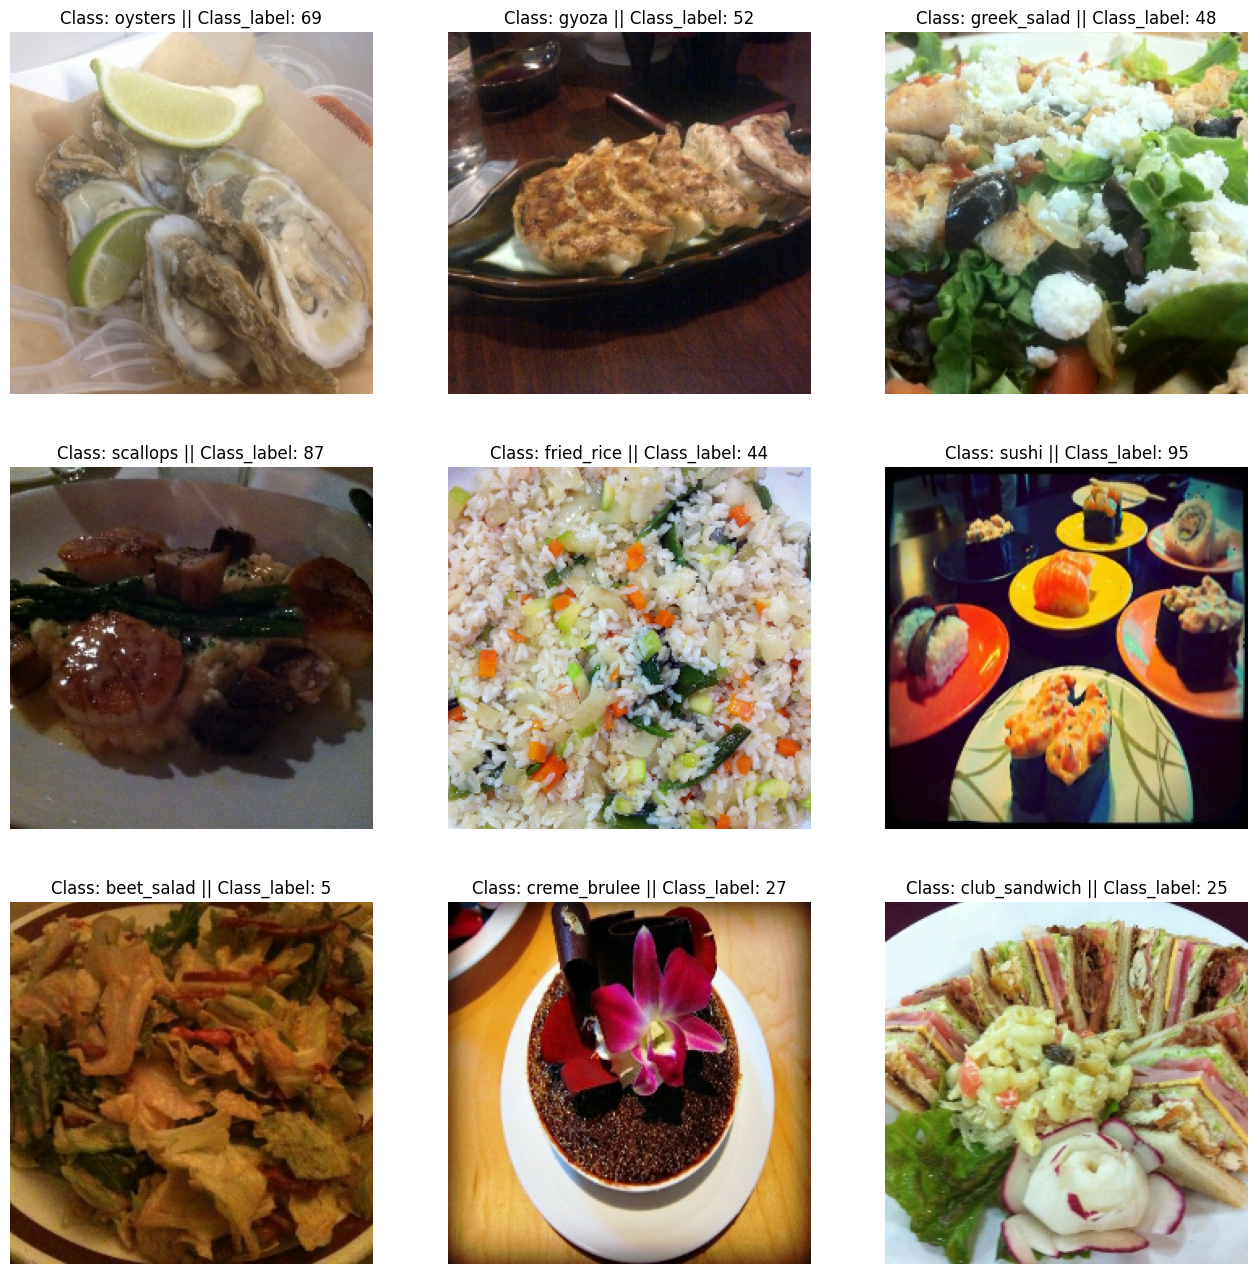

In [12]:
plt.figure(figsize=(16,16))
for i in range(9):
    for image,label in train_data.take(1):
        image = image/255.
        plt.subplot(3,3,i+1)
        plt.imshow(image[0])
        plt.title("Class: " + class_names[label[0].numpy()] + " || Class_label: " + str(label[0].numpy()))
        plt.axis(False);

In [16]:
train_data.element_spec, test_data.element_spec


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

In [17]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 with Max-Q Design, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 with Max-Q Design, compute capability 7.5


In [18]:
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

def model_checkpoint(directory, name):
    log_dir = directory + "/" + name
    m_c = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
    return m_c

In [19]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

In [20]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(101, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")

In [21]:
model.summary()

Model: "FeatureExtractionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
poolingLayer (GlobalAverageP (None, 1280)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 101)               129381    
_________________________________________________________________
activationLayer (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
for lnum, layer in enumerate(model.layers):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 inputLayer True float32 <Policy "float32">
1 efficientnetb0 False float32 <Policy "mixed_float16">
2 poolingLayer True float32 <Policy "mixed_float16">
3 outputLayer True float32 <Policy "mixed_float16">
4 activationLayer True float32 <Policy "float32">


In [23]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

hist_model = model.fit(train_data,
                       epochs = 3,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.1 * len(test_data)),
                       callbacks=[tensorboard_callback("Tensorboard","model"),                                  model_checkpoint("Checkpoints","model.ckpt")])

C:\Users\noahc\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/3
2368/2368 [==============================] - 4492s 2s/step - loss: 1.8238 - accuracy: 0.5568 - val_loss: 1.2312 - val_accuracy: 0.6796

Epoch 00001: val_accuracy improved from -inf to 0.67959, saving model to Checkpoints\model.ckpt
Epoch 2/3
2368/2368 [==============================] - 119s 50ms/step - loss: 1.2944 - accuracy: 0.6656 - val_loss: 1.1193 - val_accuracy: 0.7021

Epoch 00002: val_accuracy improved from 0.67959 to 0.70214, saving model to Checkpoints\model.ckpt
Epoch 3/3
2368/2368 [==============================] - 120s 51ms/step - loss: 1.1432 - accuracy: 0.7019 - val_loss: 1.0890 - val_accuracy: 0.7037

Epoch 00003: val_accuracy improved from 0.70214 to 0.70372, saving model to Checkpoints\model.ckpt


In [24]:
base_model.trainable = True
for layer in model.layers[1].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

In [25]:
for lnum, layer in enumerate(model.layers[1].layers[-10:]):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 block7a_se_squeeze True float32 <Policy "mixed_float16">
1 block7a_se_reshape True float32 <Policy "mixed_float16">
2 block7a_se_reduce True float32 <Policy "mixed_float16">
3 block7a_se_expand True float32 <Policy "mixed_float16">
4 block7a_se_excite True float32 <Policy "mixed_float16">
5 block7a_project_conv True float32 <Policy "mixed_float16">
6 block7a_project_bn False float32 <Policy "mixed_float16">
7 top_conv True float32 <Policy "mixed_float16">
8 top_bn False float32 <Policy "mixed_float16">
9 top_activation True float32 <Policy "mixed_float16">
